# Práctica 2: Movimiento de un robot

## Inteligencia Artificial para la Robótica
### M.U en Lógica, Computación e Inteligencia Artificial
### Universidad de Sevilla

Índice:
- [2.1 Composición de la posición](#composicion_posicion)
- [2.2 Movimiento de un robot usando comandos de velocidad](#comandos_velocidad)
- [2.3 Movimiento de un robot usando comandos de odometría](#comandos_odometria)

## Introducción

Un aspecto fundamental en el desarrollo de robots móviles es el propio movimiento. Esto no es trivial, ya que es una de las principales fuentes de incertidumbre y otras restricciones que dificultan su implementación.
Esta lección en particular introduce el concepto de la posición de un robot y cómo la abordamos en un contexto probabilístico.

La posición en sí puede tomar diversas formas según el contexto del problema:

- **Ubicación 2D**: En un contexto plano, solo necesitamos un vector 2D $[x, y]^T$ para ubicar un robot en relación con un punto de referencia, el origen $(0, 0)$.
- **Posición 2D**: En la mayoría de los casos que involucran robots móviles, la ubicación sola no es suficiente. Necesitamos un parámetro adicional conocido como orientación o *rumbo*. Por lo tanto, la posición de un robot (o pose) generalmente se expresa como $[x, y, \theta]^T$. *En el resto del curso, utilizaremos posiciones 2D.*
- **Posición 3D**: Aunque solo lo mencionaremos de pasada, para aplicaciones de robótica en el espacio 3D, como UAV o drones, no solo se agrega un tercer eje $z$, sino que para manejar la orientación en un entorno 3D necesitamos 3 componentes, es decir, cabeceo, alabeo y guiñada (roll, pitch, yaw). Este curso se centra en robots móviles en el plano, por lo que no usaremos posiciones 3D, sin embargo, la mayoría de los métodos podrían adaptarse a entornos 3D.

In [1]:
%matplotlib widget

# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats

from utils.DrawRobot import DrawRobot
from utils.tcomp import tcomp

## 2.1 Composición de la posición <a id="composicion_posicion"></a>

Dada una posición inicial $p_1$ y una posición diferencial $\Delta p$, es decir, cuánto se ha movido el robot durante un intervalo de tiempo, calculamos la posición final $p$ utilizando la función de **composición de la posición**:

$$
    p_1 = 
        \begin{bmatrix}
            x_1 \\ y_1 \\ \theta_1
        \end{bmatrix},
    \Delta p = 
        \begin{bmatrix}
            \Delta x \\ \Delta y \\ \Delta \theta
        \end{bmatrix}
$$

$$
    \begin{equation}
    p = \begin{bmatrix}
            x \\ y \\ \theta
        \end{bmatrix}
        = p_1 \oplus \Delta p
        = \begin{bmatrix}
            x_1 + \Delta x \cos \theta_1 - \Delta y \sin \theta_1 \\ 
            y_1 + \Delta x \sin \theta_1 - \Delta y \cos \theta_1 \\
            \theta_1 + \Delta \theta
          \end{bmatrix}
    \end{equation}
$$

La diferencia $\Delta p$, aunque la estamos utilizando como comando de control en este ejercicio, normalmente se calcula mediante la locomoción del robot o se percibe mediante los codificadores de las ruedas.

**Ejercicio**

Echa un vistazo a la clase `Robot()` proporcionada y sus métodos. Luego, modifica la función principal en la siguiente celda para que el robot describa un recorrido cuadrado de $8m \times 8m$, como se ve en la figura a continuación.

El robot comienza en la esquina inferior izquierda $(0, 0)$ orientado hacia el norte y se mueve en incrementos de $2 m$ en cada paso. Cada 4 pasos, girará a la derecha.

**Ejemplo**

<figure style="text-align:center">
  <img src="images/fig3-1-1.png" alt="">
  <figcaption>Fig. 1: Ruta de nuestro robot.</figcaption>
</figure>

In [5]:
class Robot():
    '''Mobile robot implementation
    
        Attr:
            pose: Expected position of the robot
    '''
    def __init__(self, mean):
        self.pose = mean

    def step(self, u):
        self.pose = tcomp(self.pose, u)
    
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)

In [10]:
def main(robot):
    
    # PARAMETERS INITIALIZATION
    num_steps = 15 # Number of robot motions
    turning = 4  # Number of steps for turning
    u = np.vstack([2., 0., 0.]) # Motion command (pose increment)
    angle_inc = -np.pi/2 # Angle increment
    
    # VISUALIZATION
    fig, ax = plt.subplots()
    #plt.ion()
    plt.draw()
    plt.xlim((-2, 10))
    plt.ylim((-2, 10))
    
    plt.grid()
    robot.draw(fig, ax)
    
    # MAIN LOOP
    for step in range(1,num_steps+1):
        
        # Check if the robot has to move in straight line or also has to turn
        # and accordingly set the third component (rotation) of the motion command 
        if step%turning == 0:
            u[2] =  angle_inc 
        else:
            u[2] = 0
             
        # Execute the motion command        
        robot.step(u)
        
        # VISUALIZATION
        fig.canvas.flush_events()
        robot.draw(fig, ax)
        fig.canvas.draw()
        plt.pause(0.1)   

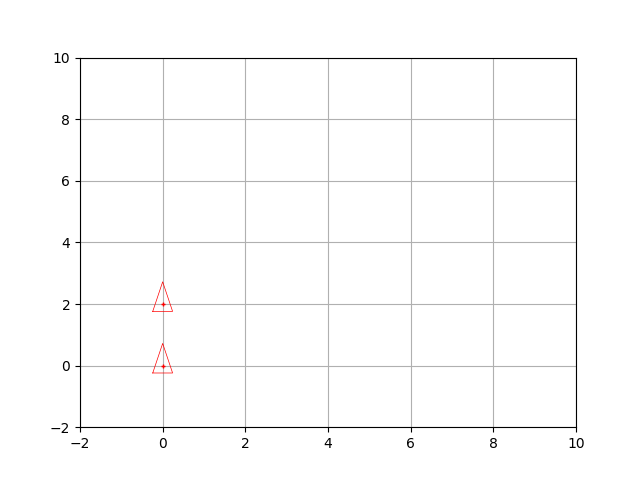

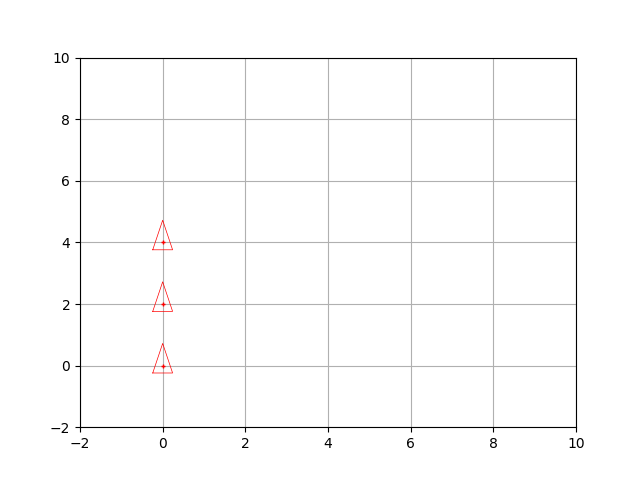

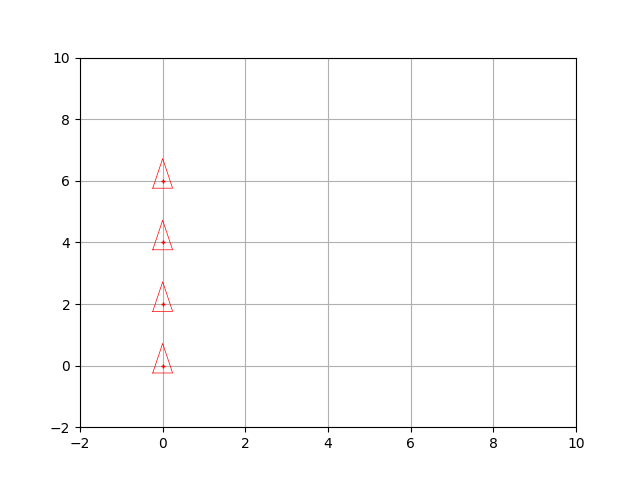

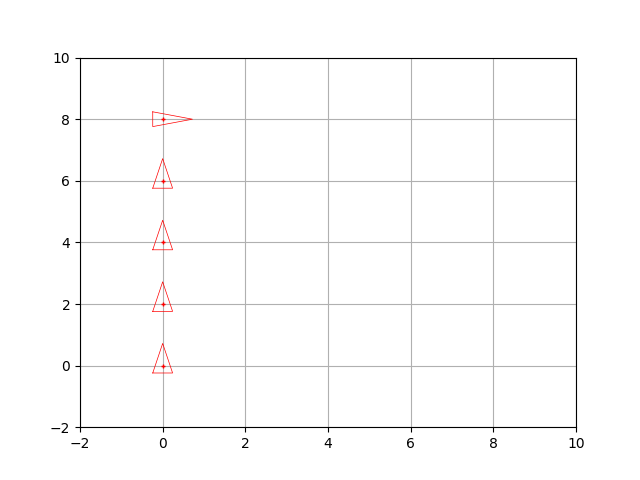

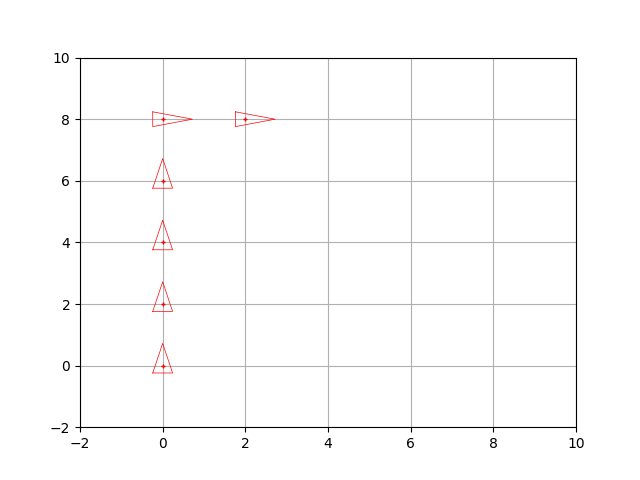

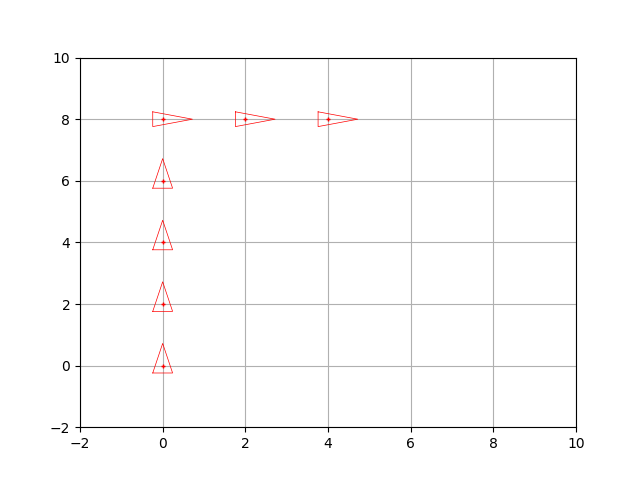

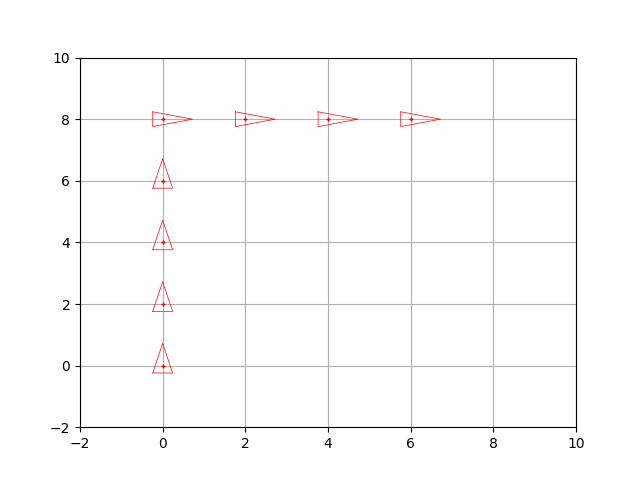

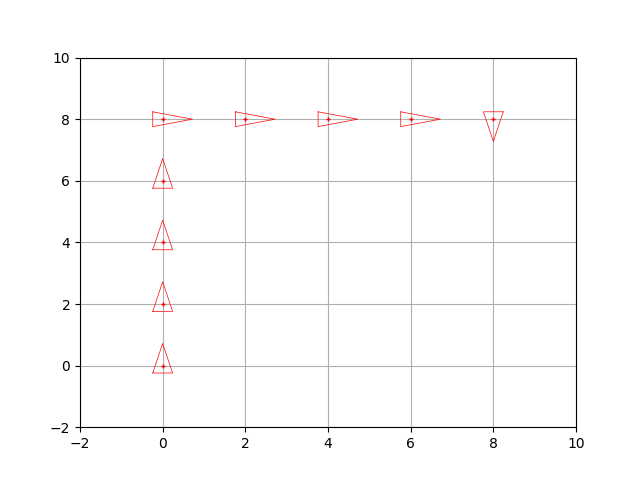

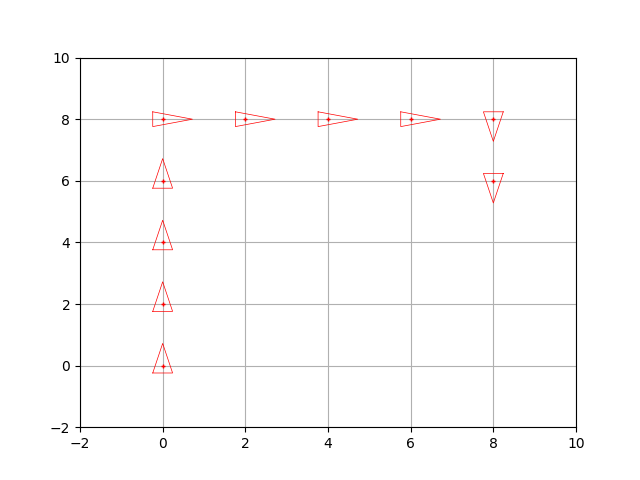

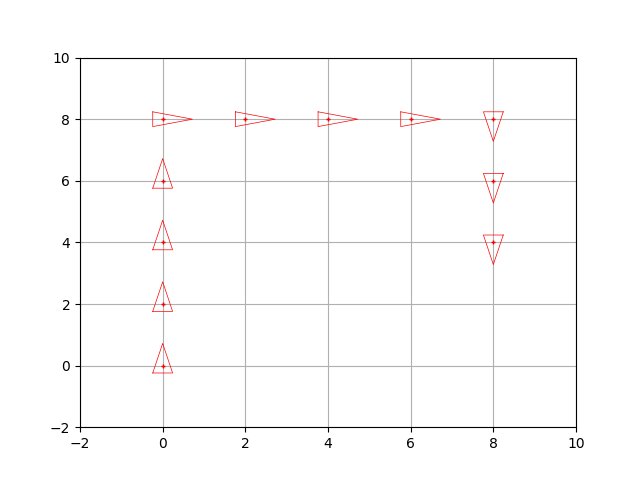

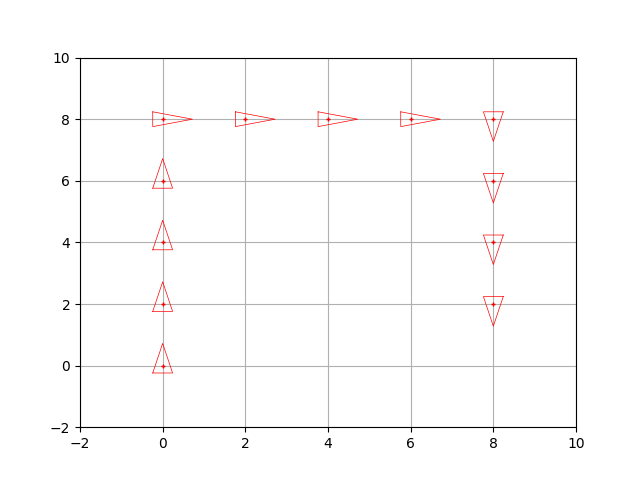

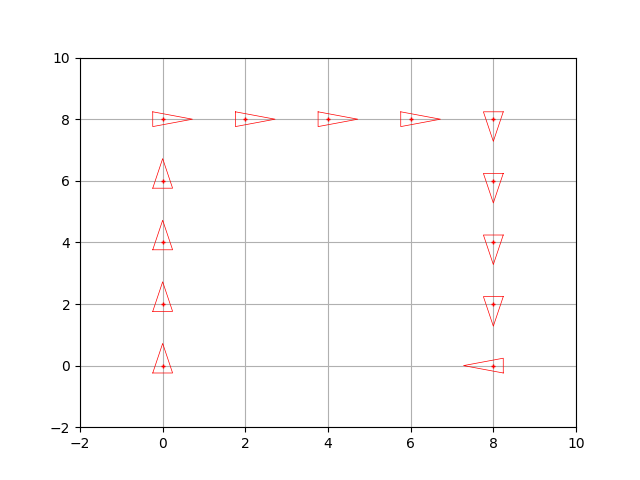

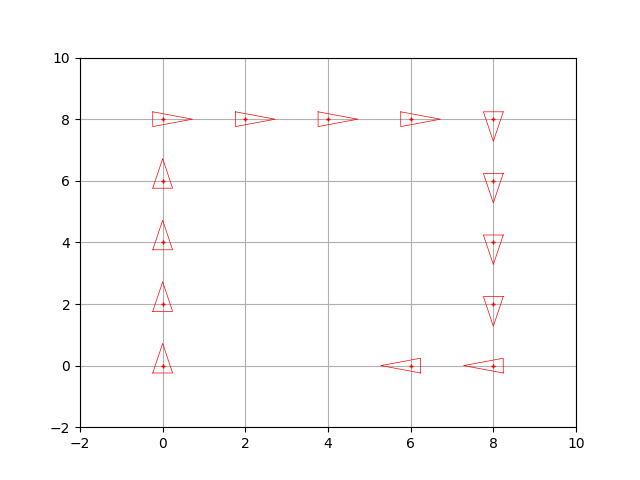

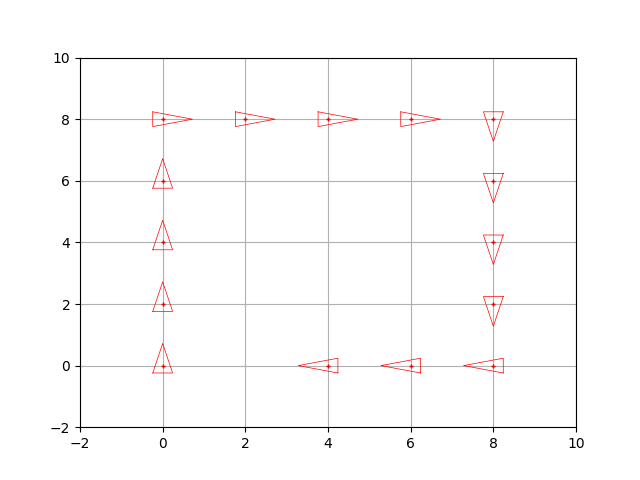

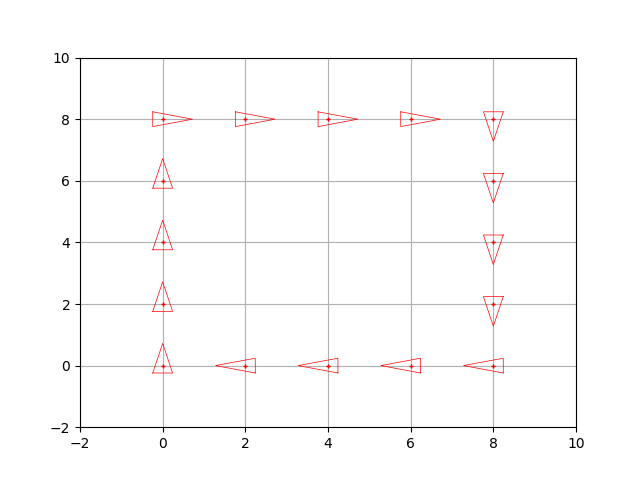

In [11]:
# RUN 
initial_pose = np.vstack([0., 0., np.pi/2])
robot = Robot(initial_pose)
main(robot)

### 2.1.1 Considerando ruido

En el caso anterior, el movimiento del robot no tenía errores, lo cual es excesivamente optimista, ya que en un caso de uso real, las condiciones del entorno son una gran fuente de incertidumbre.

Por lo tanto, tenemos que transformar el movimiento del robot en una distribución gaussiana (multidimensional).

- La media sigue siendo la posición diferencial en el ejercicio anterior.
- La covarianza es una matriz de $3 \times 3$, que define la cantidad de error en cada intervalo de tiempo.

**Ejercicio**

Ahora, vamos a agregar un ruido gaussiano al movimiento, suponiendo que la acción incremental de movimiento sigue ahora la distribución de probabilidad:

$$
    \Delta p = N(\Delta p_{given}, \Sigma_{\Delta p})
    \textit{ con } 
    \Sigma_{\Delta p}  =
        \begin{bmatrix}
            0.04 & 0 & 0 \\
            0 & 0.04 & 0 \\
            0 & 0 & 0.01
        \end{bmatrix}
    (\text{ unidades en }m^2 \text{ y } rad^2)
$$

Para hacerlo, completa la clase `NosyRobot()`, que es una clase hija de `Robot()`. Concretamente, tienes que:

- Completar esta nueva clase añadiendo una cierta cantidad de ruido al movimiento (echa un vistazo al método `step()`. *Pistas: [`np.vstack()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html), `multivariate_normal.rvs()`*
- En el método `draw()`pinta en azul la posición real del robot (`self.true_pose`) junto con la posición esperada del robot (`self.pose`) en rojo.

Ejecuta la celda varias veces para ver que el movimiento y el camino es diferente cada vez. Prueba con diferentes valores de la matriz de covarianza.

**Ejemplo**

<figure style="text-align:center">
  <img src="images/fig3-1-2.png" alt="">
  <figcaption>Fig. 2: Movimiento de nuestro robot utilizando composición de la posición. <br/>
      Contiene las posiciones esperadas (en rojo) y las posiciones reales <br/> afectadas por el ruido (en azul)</figcaption>
</figure>

In [41]:
from matplotlib.pylab import multivariate_normal


class NoisyRobot(Robot):
    """Mobile robot implementation. It's motion has a set ammount of noise.
    
        Attr:
            pose: Inherited from Robot
            true_pose: Real robot pose, which has been affected by some ammount of noise.
            covariance: Amount of error of each step.
    """
    def __init__(self, mean, covariance):
        super().__init__(mean)
        self.true_pose = mean
        self.covariance = covariance
        
    def step(self, step_increment):
        """Computes a single step of our noisy robot.
        
            super().step(...) updates the expected pose (without noise)
            Generate a noisy increment based on step_increment and self.covariance.
            Then this noisy increment is applied to self.true_pose
        """
        super().step(step_increment)
        true_step = multivariate_normal(mean = np.hstack(step_increment), cov = self.covariance)
        true_step = np.vstack(list(true_step))
        self.true_pose = tcomp(self.true_pose, true_step)
        
    def draw(self, fig, ax):
        super().draw(fig, ax)
        DrawRobot(fig, ax, self.true_pose, color='blue')

In [42]:
np.vstack([ 2.3327754,-0.1617647,-0.04034811])

array([[ 2.3327754 ],
       [-0.1617647 ],
       [-0.04034811]])

<class 'numpy.ndarray'>
[ 1.89007386 -0.16607808  0.03670232]


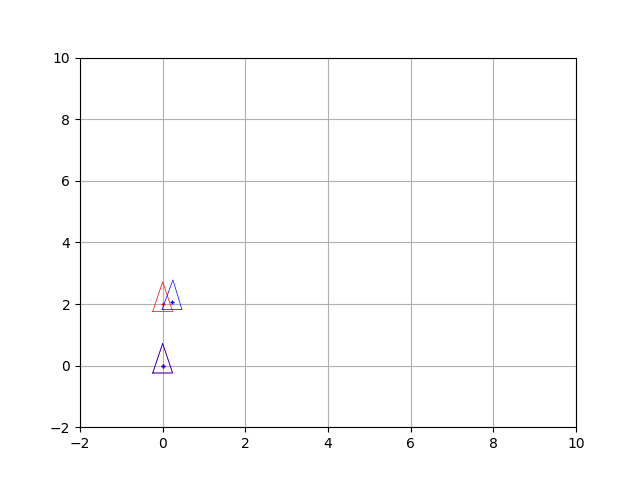

<class 'numpy.ndarray'>
[1.79316969 0.2911628  0.06176838]


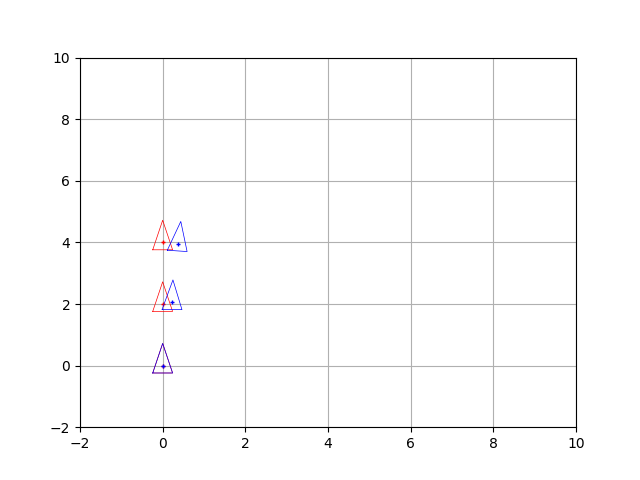

<class 'numpy.ndarray'>
[ 1.96420701 -0.01453675  0.06834787]


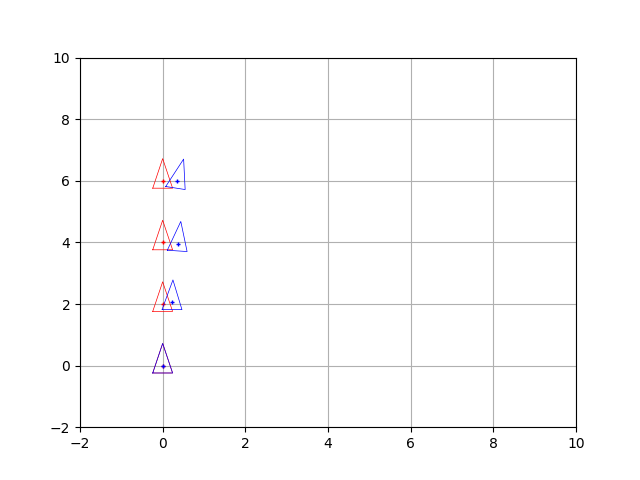

<class 'numpy.ndarray'>
[ 1.96084699 -0.07872865 -1.51049519]


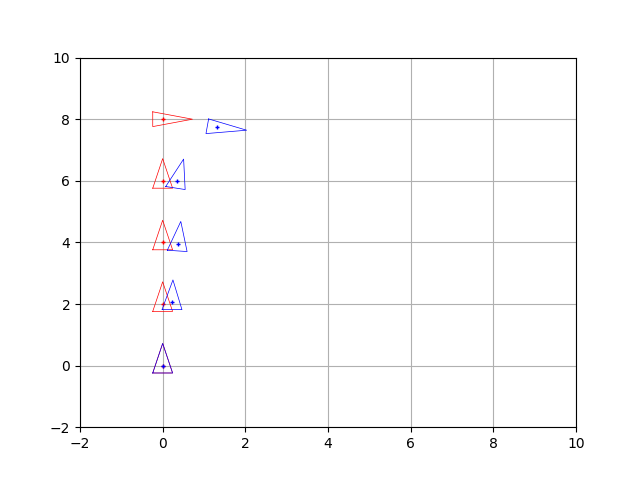

<class 'numpy.ndarray'>
[ 2.15289405 -0.11205631 -0.03369658]


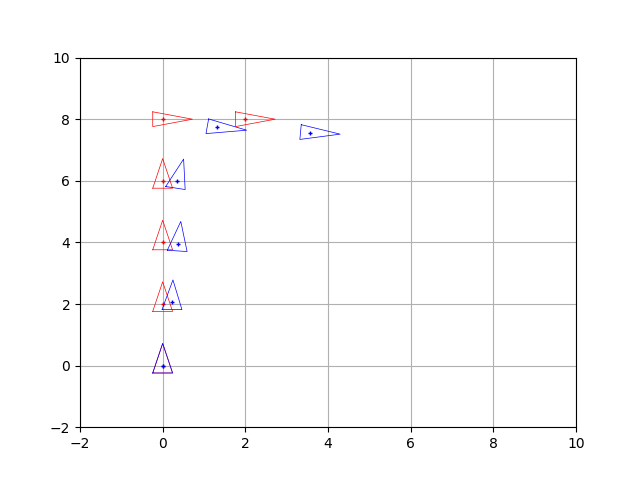

<class 'numpy.ndarray'>
[ 1.4237311  -0.1288786  -0.07545503]


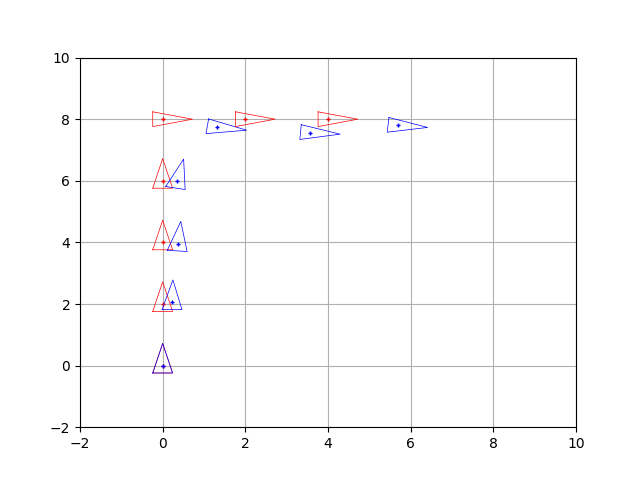

<class 'numpy.ndarray'>
[2.5822277  0.02758599 0.06521214]


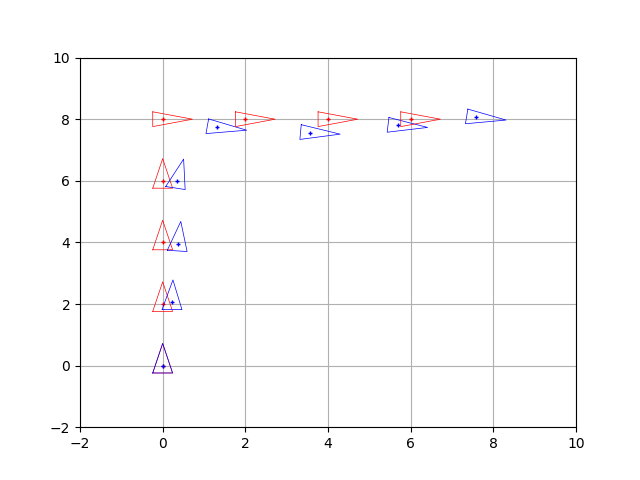

<class 'numpy.ndarray'>
[ 1.68841467  0.09874526 -1.59054039]


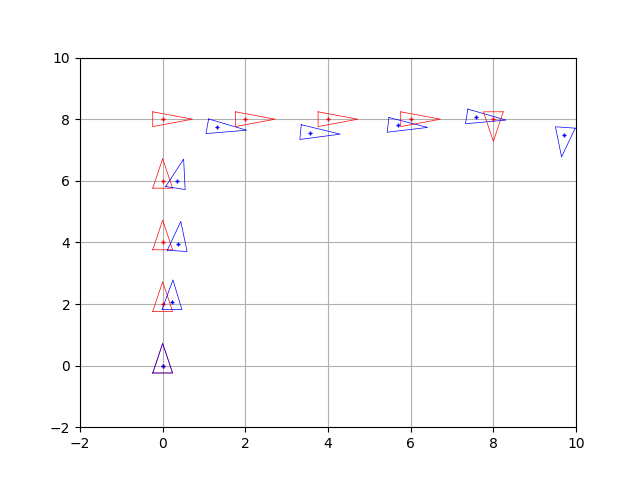

<class 'numpy.ndarray'>
[2.07926545 0.21497277 0.01035575]


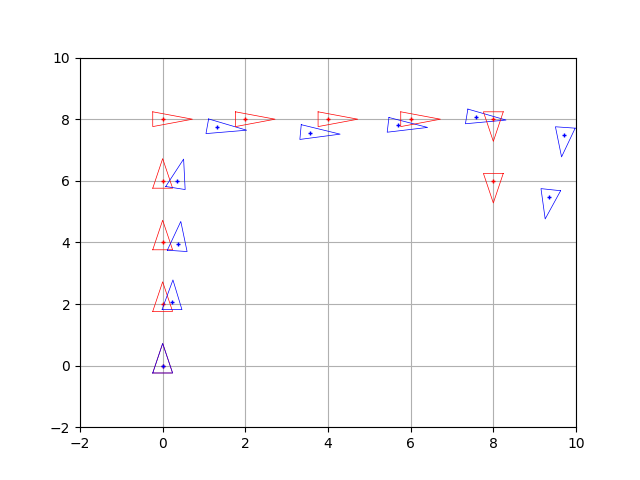

<class 'numpy.ndarray'>
[1.5089571  0.14914869 0.17004511]


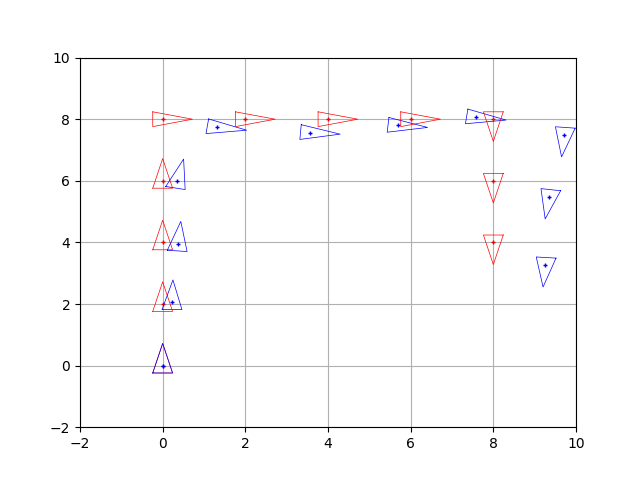

<class 'numpy.ndarray'>
[ 1.6574674  -0.11945281  0.09030494]


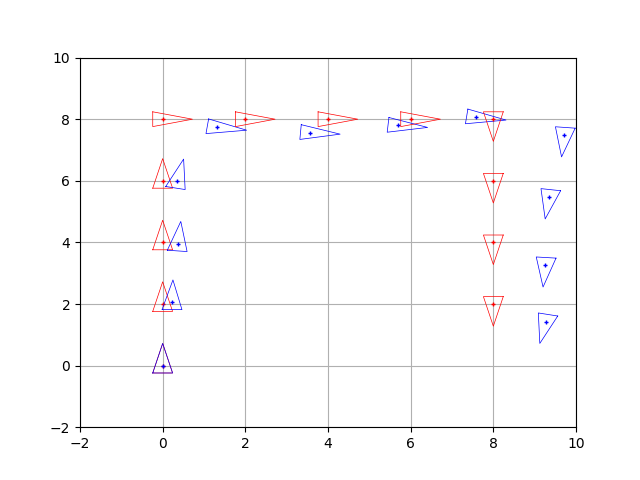

<class 'numpy.ndarray'>
[ 2.16380125 -0.33067862 -1.70629215]


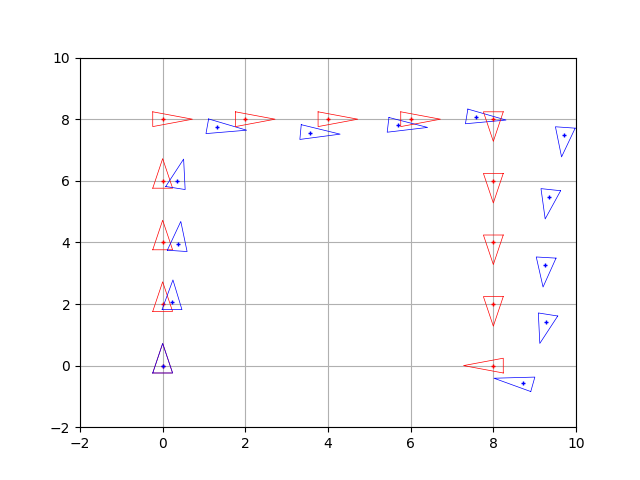

<class 'numpy.ndarray'>
[ 1.91903763 -0.04272796  0.19962081]


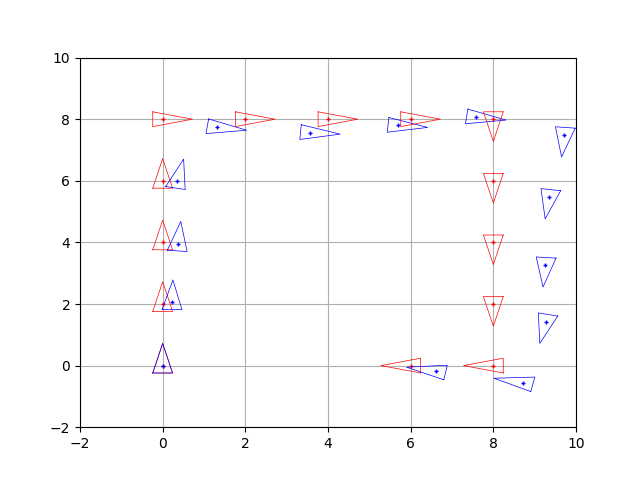

<class 'numpy.ndarray'>
[ 2.13392758  0.05845471 -0.11262336]


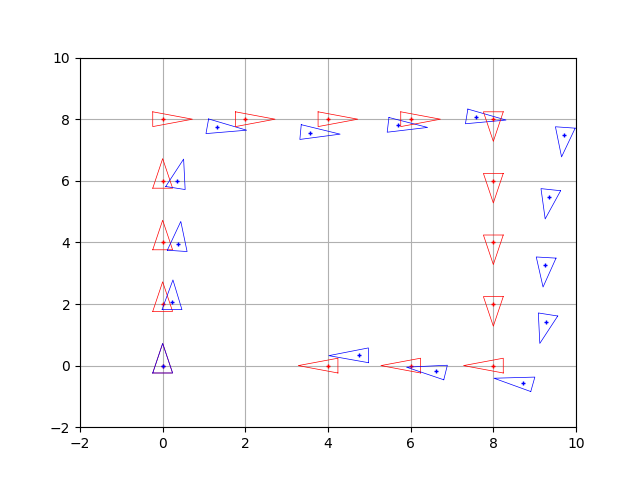

<class 'numpy.ndarray'>
[ 2.06938088  0.0971203  -0.14469485]


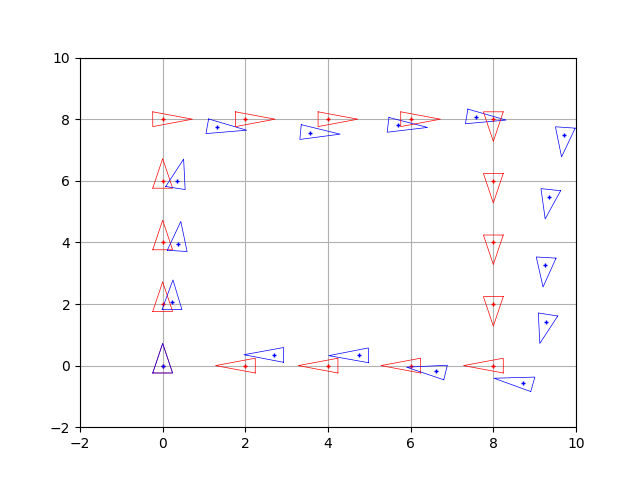

In [43]:
# RUN 
initial_pose = np.vstack([0., 0., np.pi/2])
cov = np.diag([0.04, 0.04, 0.01])  

robot = NoisyRobot(initial_pose, cov)
main(robot)

# 2.2 Movimiento de un robot usando comandos de velocidad <a id='comandos_velocidad'></a>

En el resto de este capítulo, describiremos dos modelos de movimiento probabilísticos para el movimiento en el plano: el **modelo de movimiento de velocidad** y el **modelo de movimiento de odometría**, siendo el primero el tema principal de esta sección.

El *modelo de movimiento de velocidad* se utiliza principalmente para la planificación de movimiento, donde los detalles del movimiento del robot son importantes y la información de odometría no está disponible (se calcula después del movimiento).

Este modelo de movimiento se caracteriza por el uso de dos velocidades para controlar el movimiento del robot: la **velocidad lineal** $v$ y la **velocidad angular** $w$. Por lo tanto, durante los siguientes ejercicios, las órdenes de movimiento tendrán la forma: 

$$u = \begin{bmatrix} v \\ w \end{bmatrix}$$

Concretamente, este modelo de movimiento se caracteriza por las siguientes ecuaciones:

<table>
    <tr>
        <td>

- If $w \neq 0$:

    $$
        x_t = x_{t-1} + 
        \begin{bmatrix}
            -R \sin \theta_{t-1} + R \sin(\theta_{t-1} + \Delta \theta) \\ 
            R \cos \theta_{t-1} - R \cos(\theta_{t-1} + \Delta \theta)\\
            \Delta \theta
        \end{bmatrix}
    $$

- If $w = 0$:

    $$
        x_t = x_{t-1} + v \cdot \partial t
        \begin{bmatrix}
            \cos \theta_{t-1} \\ \sin \theta_{t-1} \\ 0
        \end{bmatrix}
    $$
    <td/>       
    <td>
        $$ 
        \begin{aligned}
        v &= w \cdot R \\
        \Delta \theta &= w \cdot  \partial t
        \end{aligned}
        $$
    <td/>
  <tr/>
<table/>

In [29]:
# IMPORTS
from numpy import random

from utils.PlotEllipse import PlotEllipse

### 2.2.1 El modelo en acción

**Ejercicio**

Modifica la función `next_pose()`, utilizada en la clase `VelocityRobot` (ver a continuación), que calcula la siguiente posición de un robot dada su posición anterior $x$, el comando de movimiento de velocidad $u=[v,w]'$ y un lapso de tiempo $dt$. Concretamente, debes completar la declaración if-else que considera si el robot se mueve en línea recta ($w = 0$). *Nota: no tienes que modificar el `None` en el encabezado de la función ni en la condición `if cov is not None:`.*

En este punto, no tenemos en cuenta la incertidumbre en el sistema: ni desde la posición inicial (matriz $P_{3\times3}$) ni desde el movimiento $(v, w)$ (matriz $Q_{2\times2}$).

**Ejemplo**

<figure style="text-align:center">
  <img src="images/fig3-2-1.png" alt="">
  <figcaption>Fig. 1: Ruta de nuestro robot.</figcaption>
</figure>

In [ ]:
def next_pose(x, u, dt, cov=None):
    ''' This function takes pose x and transform it according to the motion u=[v,w]'
        applying the differential drive model.

        Args:
            x: current pose
            u: differential command as a vector [v, w]'
            dt: Time interval in which the movement occurs
            cov: covariance of our movement. If not None, then add gaussian noise
    '''
    if cov is not None:
        u += cov @ random.randn(2, 1)

    if u[1] == 0: #linear motion w=0
        next_x = np.vstack([None,
                       None,
                       None])
    else: #Non-linear motion w=!0
        R = u[0]/u[1] #v/w=r is the curvature radius
        next_x = np.vstack([None,
                       None,
                       None])

    return next_x

In [ ]:
class VelocityRobot(object):
    """ Mobile robot implementation that uses velocity commands.
    
        Attr:
            pose: expected pose of the robot in the real world (without taking account noise)
            dt: Duration of each step in seconds
    """    
    def __init__(self, mean, dt):
        self.pose = mean
        self.dt = dt
        
    def step(self, u):
        self.pose = next_pose(self.pose, u, self.dt)
        
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)

Test the movement of your robot using the demo below.

In [ ]:
def main(robot, nSteps):
          
    v = 1 # Linear Velocity 
    l = 0.5 #Half the width of the robot
        
    # MATPLOTLIB
    fig, ax = plt.subplots()
    plt.ion()
    fig.canvas.draw()
    plt.xlim((-2, 20))
    plt.ylim((-2, 30))
    
    plt.grid()
        
    # MAIN LOOP
    for k in range(1, nSteps + 1):
        #control is a wiggle with constant linear velocity
        u = np.vstack((v, np.pi / 10 * np.sin(4 * np.pi * k/nSteps)))
        
        robot.step(u)   
        
        #draw occasionally
        if (k-1)%20 == 0:
            robot.draw(fig, ax)
            fig.canvas.draw()
            plt.pause(0.1)

In [ ]:
# RUN 
dT = 0.1 # time steps size
pose = np.vstack([0., 0., 0.])

robot = VelocityRobot(pose, dT)
main(robot, nSteps=400)

### 2.2.2 Añadiendo incertidumbre

El uso de matrices jacobianas en la representación del ruido gaussiano en el movimiento de un robot está relacionado con la propagación de la incertidumbre en un modelo cinemático. La idea básica es cuantificar cómo las incertidumbres en las variables de entrada afectan las incertidumbres en las variables de salida del modelo.

Supongamos que tenemos un modelo de movimiento de robot representado por una función $g$ que toma como entrada la pose actual del robot $x_t$ y el comando de movimiento $u_t$, y produce la nueva pose del robot $x_{t+1}$. Matemáticamente, esto se puede expresar como:

$$x_{t+1} = g(x_t, u_t)$$

Ahora, si tanto la pose inicial $x_t$ como el comando de movimiento $u_t$ tienen ciertas incertidumbres, puedes usar jacobianas para cuantificar cómo esas incertidumbres se propagan a través del modelo de movimiento.

La matriz jacobiana $\frac{\partial g}{\partial x_t}$ representa cómo las pequeñas variaciones en la pose inicial afectan las variaciones en la nueva pose. Similarmente, la matriz jacobiana $\frac{\partial g}{\partial u_t}$ representa cómo las pequeñas variaciones en el comando de movimiento afectan las variaciones en la nueva pose.

La propagación de incertidumbre se puede expresar utilizando la matriz de covarianza. Supongamos que la matriz de covarianza de la pose inicial $x_t$ es $P_t$, y la matriz de covarianza del comando de movimiento $u_t$ es $Q_t$. Entonces, la nueva matriz de covarianza $P_{t+1}$ después de aplicar el movimiento se puede calcular de la siguiente manera:

$$P_{t+1} = \frac{\partial g}{\partial x_t} \cdot P_t \cdot {\frac{\partial g}{\partial x_t}}^T + \frac{\partial g}{\partial u_t} \cdot Q_t \cdot {\frac{\partial g}{\partial u_t}}^T$$

Esta ecuación tiene en cuenta cómo las incertidumbres en la pose inicial y en el comando de movimiento contribuyen a la incertidumbre en la nueva pose después de aplicar el modelo de movimiento.

En resumen, las jacobianas permiten cuantificar cómo las pequeñas variaciones en las variables de entrada afectan las variaciones en las variables de salida de un modelo, y esta información se utiliza para propagar la incertidumbre a través del modelo.

Ahora incluiremos incertidumbre en el ejercicio anterior, cambiando el comportamiento de la clase robot que has implementado.

A diferencia del robot ruidoso en el ejercicio 2.1, usaremos las ecuaciones del modelo de movimiento de velocidad y sus respectivas jacobianas para realizar un seguimiento de cuán seguro estamos de la posición real del robot (es decir, la posición del robot ahora también es una distribución gaussiana).

Por lo tanto, tenemos que lidiar con dos distribuciones gaussianas:
- la **posición** $\sim(x_t, \Sigma_{x_t})$ en el tiempo $t$,
- y el **comando de movimiento** $\sim(u_t, \Sigma_{u_t})$, que se aplica durante un intervalo de tiempo $\partial t$.

La covarianza de este movimiento ($\Sigma_{u_t}$, `Q` en el código) se define como se muestra a continuación. Es constante durante la ejecución de nuestro código:

$$
    \Sigma_{u_t} = \begin{bmatrix}
            \sigma_v^2 & 0 \\
            0 &  \sigma_w^2
        \end{bmatrix}
$$

Mientras que la covarianza de la posición $\Sigma_{x_t}$ (`P_t` en el código) debe actualizarse en cada paso de la ejecución. Para lograr esto, tendrás que usar:

$$\Sigma_{x_t} =  \frac{\partial g}{\partial x_{t-1}} \cdot \Sigma_{x_{t-1}} \cdot {\frac{\partial g}{\partial x_{t-1}}}^T + \frac{\partial g}{\partial u_{t}} \cdot \Sigma_{u_t} \cdot {\frac{\partial g}{\partial u_{t}}}^T$$

Donde $\partial g / \partial x_{t-1}$ y $\partial g / \partial u_{t}$ (`JacF_x` y `JacF_u` en el código) son las jacobianas de nuestro modelo de movimiento evaluadas en la posición anterior $x_{t-1}$ y el comando actual $u_t$.



**Ejercicio extra**
      
1. Completa el siguiente código para calcular la matriz de covarianza $\Sigma_{x_t}$ (`$P_k$` en el código).

In [ ]:
def next_covariance(x, P, Q, u, dt):
    ''' Compute the covariance of a robot following the velocity motion model

        Args:
            x: current pose (before movement)
            u: differential command as a vector [v, w]''
            dt: Time interval in which the movement occurs
            P: current covariance of the pose
            Q: covariance of our movement.
    '''
    # Aliases
    v = u[0, 0]
    w = u[1, 0]

    sx, cx = np.sin(x[2, 0]), np.cos(x[2, 0]) #sin and cos for the previous robot heading
    si, ci = np.sin(u[1, 0]*dt), np.cos(u[1, 0]*dt) #sin and cos for the heading increment
    R = u[0, 0]/u[1, 0] #v/w Curvature radius

    if u[1, 0] == 0:  #linear motion w=0 --> R = infinite
        #TODO JACOBIAN HERE
        JacF_x = np.array([
            None,
            None,
            None
        ])
        JacF_u = np.array([
            None,
            None
        ])
    else: #Non-linear motion w=!0
        # TODO JACOBIAN HERE
        JacF_x = np.array([
            None,
            None,
            None
        ])

        JacF_u = (
            np.array([
                None,
                None,
                None
            ])@
            np.array([
                [1/w, -v/w**2],
                [0, dt]
            ])
        )
    #prediction steps
    Pt = ( None @ None @ None ) + ( None @ None @ None )
    
    return Pt

2. Completa los métodos:

   - `step` para obtener la verdadera posición del robot (ground-truth) utilizando la matriz $Q$,
   - y el método `draw()` para trazar una elipse que represente la incertidumbre sobre la posición del robot centrada en la posición esperada del robot (`self.pose`), así como marcas que representen las verdaderas posiciones del robot.
  

**Ejemplo**

<figure style="text-align:center">
  <img src="images/fig3-2-2.png" alt="">
  <figcaption>Fig. 2: Movimiento de un robot usando comandos de velocidad. <br/> Representación de la posición esperada (en rojo), la posición verdadera (como puntos) <br/> y la elipse de confianza.</figcaption>
</figure>

In [ ]:
class NoisyVelocityRobot(VelocityRobot):
    """ Mobile robot implementation that uses velocity commands.
       
        Attr:
            [...]: Inherited from VelocityRobot
            true_pose: expected pose of the robot in the real world (noisy)
            cov_pose: Covariance of the pose at each step
            cov_move: Covariance of each movement. It is a constant

    """
    
    def __init__(self, mean, cov_pose, cov_move, dt):
        super().__init__(mean, dt)
        self.true_pose = mean
        self.cov_pose = cov_pose
        self.cov_move = cov_move
        
    def step(self, u):
        self.cov_pose = next_covariance(None, None, None, None, None)
        
        super().step(u)
        self.true_pose = next_pose(None, None, None, cov=None)
        
    def draw(self, fig, ax):
        super().draw(fig, ax)
        el = PlotEllipse(fig, ax, None, None)
        ax.plot(None, None, 'o', color=el[0].get_color())

In [ ]:
# RUN
dT = 0.1 # time steps size

SigmaV = 0.1 #Standard deviation of the linear velocity. 
SigmaW = 0.1 #Standard deviation of the angular velocity
nSteps = 400 #Number of motions

P = np.diag([0.2, 0.4, 0.]) #pose covariance matrix 3x3
Q = np.diag([SigmaV**2, SigmaW**2]) #motion covariance matrix 2x2

robot = NoisyVelocityRobot(np.vstack([0., 0., 0.]), P, Q, dT)
main(robot, nSteps=nSteps)

## 2.3. Movimiento de un robot usando comandos de odometría <a id='comandos_odometria'></a>

El *modelo de movimiento de odometría* es más adecuado para realizar un seguimiento y estimar la posición del robot en contraste con el *modelo de velocidad*. La razón es que la mayoría de los robots reales proporcionan algún tipo de *información de odometría*, una medida de cuánto se ha movido el robot en realidad, cuya precisión la hace útil para realizar un seguimiento de la posición.

Aunque técnicamente es una medida en lugar de un comando de control, lo tratamos como control para simplificar el modelado. Los comandos de odometría tienen la forma:

$$
    u_t = \begin{bmatrix}
            \Delta x  \\
            \Delta y \\
            \Delta \theta
        \end{bmatrix}
$$

Implementaremos este modelo de movimiento tanto de forma analítica como usando muestreo.

In [ ]:
# IMPORTS
from utils.pause import pause
from utils.Jacobians import J1, J2

### 2.3.1 Forma analítica

Al igual que hicimos en el ejercicio 2.1, la forma analítica del modelo de movimiento de odometría utiliza la composición de posiciones para modelar el movimiento del robot, proporcionando solo una noción de cuánto ha cambiado la posición, no cómo llegó allí.

$$
    p_1 \oplus \Delta p
    = \begin{bmatrix}
        x_1 + \Delta x \cos \theta_1 - \Delta y \sin \theta_1 \\ 
        y_1 + \Delta x \sin \theta_1 - \Delta y \cos \theta_1 \\
        \theta_1 + \Delta \theta
      \end{bmatrix}
$$

En este ejercicio se realiza un seguimiento de la matriz de covarianza de la posición $(P)$, utilizando las jacobianas de este modelo de movimiento.

**Ejercicio**

De manera similar al ejercicio 2.1, moveremos un robot a lo largo de un cuadrado de 8 por 8 (en metros), en incrementos de 2 m. En este caso, debes completar:

- El método `step()` para calcular la nueva posición esperada (`self.pose`), la nueva posición verdadera (ground truth `self.true_pose`) después de agregar algo de ruido al comando de movimiento $u$ de acuerdo con `Q`, y para actualizar la incertidumbre sobre la posición del robot (matriz de covarianza `self.P`).
- El método `draw()` para trazar la incertidumbre de la pose (como una elipse) y la posición verdadera (ground truth).

Vamos a considerar la siguiente matriz de covarianza de movimiento:

$$
    \Sigma_{\Delta_p} = \begin{bmatrix}
        0.04 & 0 & 0 \\
        0 & 0.04 & 0 \\
        0 & 0 & 0.01
    \end{bmatrix}
$$

**Ejemplo**

<figure style="text-align:center">
  <img src="images/fig3-3-1.png" width="400" alt="">
  <figcaption>Fig. 1: Movimiento de un robot usando comandos de odometría. <br/> Representación de la posición esperada (en rojo), la posición verdadera (como puntos) <br/> y la elipse de confianza.</figcaption>
</figure>

In [ ]:
class Robot():
    """ Simulation of a robot base
    
        Attrs:
            pose: Expected pose of the robot
            P: Covariance of the current pose
            true_pose: Real pose of the robot(affected by noise)
            Q: Covariance of the movement
    """
    def __init__(self, x, P, Q):
        self.pose = x
        self.P = P
        self.true_pose = self.pose
        self.Q = Q
        
    def step(self, u):
        # TODO Update expected pose
        self.pose = tcomp(None, None)
        
        # TODO Generate true pose 
        noisy_u = np.vstack(None)
        self.true_pose = tcomp(None, None)
        
        # TODO Update covariance
        JacF_x = J1(None, None)
        JacF_u = J2(None, None)

        self.P = (
            (None @ None @ None) 
            + (None @ None @ None)
        )
    
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)
        el = PlotEllipse(fig, ax, None, None)
        ax.plot(None, None, 'o', color=el[0].get_color())
  

In [ ]:
def demo_odometry_commands_analytical(robot):  
    # MATPLOTLIB
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 11])
    ax.set_ylim([-3, 11])
    plt.ion()
    plt.grid()
    plt.tight_layout()
    fig.canvas.draw()
    
    # MOVEMENT PARAMETERS
    nSteps = 15
    ang = -np.pi/2 # angle to turn in corners
    u = np.vstack((2., 0., 0.))
    
    # MAIN LOOP
    for i in range(nSteps):
        # change angle on corners
        if i % 4 == 3:
            u[2, 0] = ang

        #Update positions
        robot.step(u)

        # Restore angle iff changed
        if i % 4 == 3:
            u[2, 0] = 0

        # Draw every loop
        robot.draw(fig, ax)
        fig.canvas.draw()
        plt.pause(0.3)

In [ ]:
x = np.vstack([0., 0., np.pi/2]) # pose inicial

# Probabilistic parameters
P = np.diag([0., 0., 0.])
Q = np.diag([0.04, 0.04, 0.01])

robot = Robot(x, P, Q)
demo_odometry_commands_analytical(robot)

### 2.3.2 Usando muestreo

La forma analítica utilizada anteriormente, aunque útil para los algoritmos probabilísticos que cubriremos en este curso, no funciona bien para algoritmos de muestreo como los filtros de partículas.

La razón es que, si generamos muestras aleatorias de las distribuciones gaussianas generadas en el ejercicio anterior, encontraremos algunas posiciones que no son factibles para el movimiento no holonómico de un robot, es decir, no corresponden a un comando de velocidad $(v, w)$ con ruido.

Ahora modelamos el movimiento del robot como una secuencia de acciones:

1. **Girar** ($\theta_1$): para orientarse al punto de destino.
2. **Avanzar** ($d$): para llegar al destino.
3. **Girar** ($\theta_2$): para llegar al ángulo deseado.

Entonces, este tipo de orden se expresa como:

$$
    u_t = \begin{bmatrix}
            \theta_1  \\
            d \\
            \theta_2
        \end{bmatrix}
$$

Se puede generar fácilmente a partir de las posiciones de odometría \([\hat x_t, \hat y_t,\hat \theta_t]'\) y \([\hat x_{t-1}, \hat y_{t-1},\hat \theta_{t-1}]'\) dadas las siguientes ecuaciones:

$$
    \begin{equation}
    \theta_1 =atan2(\hat y_t -\hat y_{t-1}, \hat x_t -\hat x_{t-1})- \hat \theta_{t-1} \\
    d = \sqrt{(\hat y_t -\hat y_{t-1})^2 + (\hat x_t -\hat x_{t-1})^2} \\
    \theta_2  = \hat{\theta}_t - \hat{\theta}_{t-1} - \theta_1
    \end{equation}
$$

**Ejercicio**

1. Implementa una función que, dadas las poses de odometría mencionadas anteriormente  $[\hat x_t, \hat y_t,\hat \theta_t]'$ y $[\hat x_{t-1}, \hat y_{t-1},\hat \theta_{t-1}]'$, genere una orden $u_t = [ \theta_1, d , \theta_2 ]'$

In [ ]:
def generate_move(pose_now, pose_old):
    diff = pose_now - pose_old
    theta1 = np.arctan2(None) - None
    d = np.sqrt(None)
    theta2 = None
    return np.vstack((theta1, d, theta2))

In [ ]:
generate_move(np.vstack([0., 0., 0.]), np.vstack([1., 1., np.pi/2]))

  Salida esperada:

  ```
  array([[-3.92699082],
       [ 1.41421356],
       [ 2.35619449]])
  ```

2. Utilizando la acción de control resultante $u_t = [\hat \theta_1, \hat d, \hat \theta_2]'$ podemos modelar el ruido de la acción de la siguiente manera:

  $$
    \begin{equation}
        \theta_1 = \hat\theta_1 + \text{muestra}\left(\alpha_0 \hat\theta_1^2 + \alpha_1 \hat d^2 \right) \\
        d = \hat d + \text{muestra}\left(\alpha_2 \hat d^2 + \alpha_3 \left(\hat\theta_1^2 + \hat d^2 \right) \right) \\
        \theta_2 = \hat\theta_2 + \text{muestra}\left(\alpha_0 \hat\theta_2^2 + \alpha_1 \hat d^2\right)
    \end{equation}
  $$

  Donde $\text{muestra}(b)$ genera un valor aleatorio de una distribución $N(0, b)$. El vector $\alpha = [\alpha_0, \dots, \alpha_3]$ (`a` en el código), modela el ruido intrínseco del robot.

  La pose del robot al final del movimiento se calcula de la siguiente manera:

$$
    \begin{equation}
        x_t = x_{t-1} + d \cos\left(\theta_{t-1} + \theta_1 \right) \\
        y_t = y_{t-1} + d \sin\left(\theta_{t-1} + \theta_1 \right) \\
        \theta_t = \theta_{t-1} +  \theta_1 +  \theta_2
    \end{equation}
$$

Completa los métodos `step()` y `draw()` para:
- Actualizar la pose esperada del robot y generar nuevas muestras.
- Dibujar la pose real del robot (sin el ángulo) como un conjunto de partículas (muestras de posibles puntos en los que el robot podría estar).

Juega con diferentes valores de 'a'. Para mejorar esta visualización, el robot se moverá en incrementos de $0.5$ y vamos a dibujar las partículas cada 4 incrementos.

**Ejemplo**

<figure style="text-align:center">
  <img src="images/fig3-3-2.png" width="400" alt="">
  <figcaption>Fig. 1: Movimiento de un robot usando comandos de odometría en forma de muestreo. <br/> Representación de la posición esperada (en rojo) y las muestras (como conjuntos de puntos)</figcaption>
</figure>

In [ ]:
class SampledRobot(object):
    def __init__(self, mean, a, n_samples):
        self.pose = mean
        self.a = a
        self.samples = np.tile(mean, n_samples)
        
    def step(self, u):
        # TODO Update pose
        ang = self.pose[2, 0] + u[0, 0]
        self.pose[0, 0] += None
        self.pose[1, 0] += None
        self.pose[2, 0] = None
                
        # TODO Generate new samples
        sample = lambda b: stats.norm(loc=0, scale=b).rvs(size=self.samples.shape[1])
        
        u2 = u**2
        
        noisy_u = u + np.vstack((
            sample(None),
            sample(None),
            sample(None)
        ))
        
        # TODO Update particles (robots) poses
        ang = self.samples[2, :] + noisy_u[0, :]
        
        self.samples[0, :] += None
        self.samples[1, :] += None
        self.samples[2, :] = None
        
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)
        ax.plot(None[0, :], None[1, :], '.')   

In [ ]:
def demo_odometry_commands_sample(robot):
    # PARAMETERS
    inc = .5
    show_each = 4
    limit_iterations = 32
    
    # MATPLOTLIB
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 11])
    ax.set_ylim([-3, 11])
    plt.ion()
    plt.grid()
    plt.tight_layout()
    
    # MAIN LOOP
    robot.draw(fig, ax)
    inc_pose = np.vstack((0., inc, 0.))
    
    for i in range(limit_iterations):
        if i == 16:
            inc_pose[0, 0] = inc
            inc_pose[1, 0] = 0
            inc_pose[2, 0] = -np.pi/2
            
        u = generate_move(robot.pose+inc_pose, robot.pose)
        
        robot.step(u)
        
        if i == 16:
            inc_pose[2, 0] = 0
 
        if i % show_each == show_each-1:
            robot.draw(fig, ax)
            fig.canvas.draw()
            plt.pause(0.1)

In [ ]:
# RUN 
n_particles = 100
a = np.array([.07, .07, .03, .05])
x = np.vstack((0., 0., np.pi/2))

robot = SampledRobot(x, a, n_particles)
demo_odometry_commands_sample(robot)
plt.close()

## Conclusiones

En la celda siguiente, comenta lo que se ha hecho en el cuaderno, lo que has encontrado interesante o cualquier otra consideración relevante.

<span style="color:green">**Escribe tu respuesta aquí**</span>